# HORSE2ZEBRA BACKUP

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

# Load Horse2Zebra data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#batch_size = 64
batch_size = 5
color_channels = 3
image_size = (256,256)

dataroot = r"/content/drive/MyDrive/bachelor - cyclegan/horse2zebra/train/A/"
dataset_horse_train = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_train_horse = torch.utils.data.DataLoader(dataset_horse_train, batch_size=batch_size,
                                         shuffle=True, num_workers = 1)

dataroot = r"/content/drive/MyDrive/bachelor - cyclegan/horse2zebra/test/A/"
dataset_horse_test = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_test_horse = torch.utils.data.DataLoader(dataset_horse_test, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

dataroot = r"/content/drive/MyDrive/bachelor - cyclegan/horse2zebra/train/B/"
dataset_zebra_train = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=batch_size,
                                         shuffle=True, num_workers = 1)

dataroot = r"/content/drive/MyDrive/bachelor - cyclegan/horse2zebra/test/B/"
dataset_zebra_test = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0, 0, 0), (1, 1, 1)),
                              ]))
dataloader_zebra_test = torch.utils.data.DataLoader(dataset_zebra_test, batch_size=batch_size,
                                         shuffle=True, num_workers = 1)

In [4]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


#Generator

In [5]:
def conv_norm_act(in_dim, out_dim, kernel_size, stride, padding=0,
                  norm=nn.BatchNorm2d, relu=nn.ReLU):
    return nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, bias=False),
        norm(out_dim),
        relu())


def dconv_norm_act(in_dim, out_dim, kernel_size, stride, padding=0,
                   output_padding=0, norm=nn.BatchNorm2d, relu=nn.ReLU):
    return nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride,
                           padding, output_padding, bias=False),
        norm(out_dim),
        relu())
    
class ResiduleBlock(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ResiduleBlock, self).__init__()

        conv_bn_relu = conv_norm_act

        self.ls = nn.Sequential(nn.ReflectionPad2d(1),
                                conv_bn_relu(in_dim, out_dim, 3, 1),
                                nn.ReflectionPad2d(1),
                                nn.Conv2d(out_dim, out_dim, 3, 1),
                                nn.BatchNorm2d(out_dim))

    def forward(self, x):
        return x + self.ls(x)


class Generator(nn.Module):

    def __init__(self, dim=64):
        super(Generator, self).__init__()

        conv_bn_relu = conv_norm_act
        dconv_bn_relu = dconv_norm_act

        self.ls = nn.Sequential(nn.ReflectionPad2d(3),
                                conv_bn_relu(3, dim * 1, 7, 1),
                                conv_bn_relu(dim * 1, dim * 2, 3, 2, 1),
                                conv_bn_relu(dim * 2, dim * 4, 3, 2, 1),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                ResiduleBlock(dim * 4, dim * 4),
                                dconv_bn_relu(dim * 4, dim * 2, 3, 2, 1, 1),
                                dconv_bn_relu(dim * 2, dim * 1, 3, 2, 1, 1),
                                nn.ReflectionPad2d(3),
                                nn.Conv2d(dim, 3, 7, 1),
                                nn.Tanh())

    def forward(self, x):
        return self.ls(x)

# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#           nn.Linear(100,2848),
#           nn.BatchNorm1d(2848),
#           nn.LeakyReLU(0.2),
#           nn.Linear(2848,2848),
#           nn.BatchNorm1d(2848),
#           nn.LeakyReLU(0.2),
#           nn.Linear(2848,2848),
#           nn.BatchNorm1d(2848),
#           nn.LeakyReLU(0.2),
#           nn.Linear(2848,2848),
#           nn.BatchNorm1d(2848),
#           nn.LeakyReLU(0.2),
#           nn.Linear(2848,784),
#           nn.Tanh()
#         )

        
#     def forward(self, x):
        
#         x = self.model(x)
#         x = x.view(x.size(0), 1, 28, 28)
#         return x

In [ ]:
# norm_layer = nn.InstanceNorm2d
# class ResBlock(nn.Module):
#     def __init__(self, f):
#         super(ResBlock, self).__init__()
#         self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
#                                   nn.Conv2d(f, f, 3, 1, 1))
#         self.norm = norm_layer(f)
#     def forward(self, x):
#         return F.relu(self.norm(self.conv(x)+x))

# class Generator(nn.Module):
#     def __init__(self, f=64, blocks=9):
#         super(Generator, self).__init__()
#         layers = [nn.ReflectionPad2d(3),
#                   nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
#                   nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
#                   nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
#         for i in range(int(blocks)):
#             layers.append(ResBlock(4*f))
#         layers.extend([
#                 nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
#                 nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
#                 nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
#                 nn.Tanh()])
#         self.conv = nn.Sequential(*layers)
        
#     def forward(self, x):
#         return self.conv(x)

# Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
          nn.Conv2d(3, 64, 4, 2, 1, bias=False),
          nn.Dropout(p=0.3),
          nn.LeakyReLU(0.2),
          nn.Conv2d(64, 128, 4, 2, 1, bias=False),
          nn.Dropout(p=0.3),
          nn.LeakyReLU(0.2),
          nn.Conv2d(128, 256, 4, 2, 1, bias=False),
          nn.Dropout(p=0.3),
          nn.LeakyReLU(0.2),
          nn.Conv2d(256, 512, 4, 1, 1, bias=False),
          nn.Dropout(p=0.3),
          nn.LeakyReLU(0.2),
          nn.Conv2d(512, 4, 4, 1, 1, bias=False),
          nn.Sigmoid(),
        )
    
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

# Train loop

RuntimeError: ignored

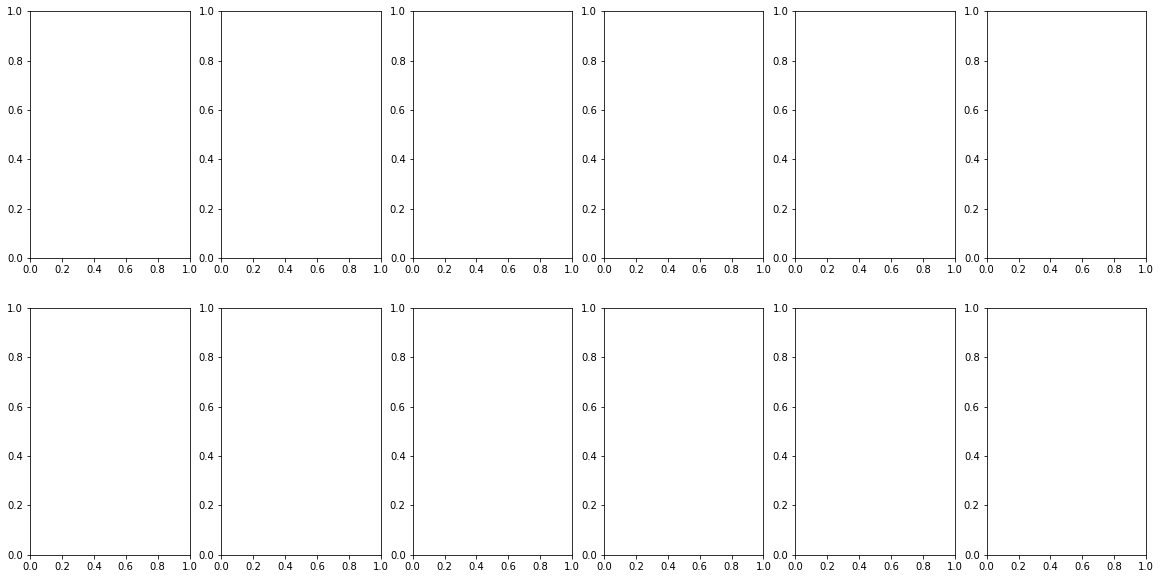

In [8]:
#Initialize networks
d_a = Discriminator().to(device)
d_b = Discriminator().to(device)
g_ab = Generator().to(device)
g_ba = Generator().to(device)
d_a_opt = torch.optim.Adam(d_a.parameters(), 0.0004, (0.5, 0.999))
d_b_opt = torch.optim.Adam(d_b.parameters(), 0.0004, (0.5, 0.999))
g_ab_opt = torch.optim.Adam(g_ab.parameters(), 0.0001, (0.5, 0.999))
g_ba_opt = torch.optim.Adam(g_ba.parameters(), 0.0001, (0.5, 0.999))

plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
discriminator_final_layer = torch.sigmoid

for epoch in range(num_epochs):
    for minibatch_no, ((a, target_a), (b, target_b)) in enumerate(zip(dataloader_train_horse, dataloader_zebra_train)):
        

        # It is probably necessary to call zero_grad and detach for some of these models. I do not know which ones yet.
        
        d_a.zero_grad()
        d_b.zero_grad()
        g_ab.zero_grad()
        g_ba.zero_grad()
        #remember to detach x_fake before using it to compute the discriminator loss
        #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
        #x_fake = x_fake.detach()
        
        
        
        # Get all images and predictions ready
        # Get real a and b images ready
        real_a = a.to(device)
        real_b = b.to(device)

        # Get real/fake prediction from discriminator
        pred_a = d_a(real_a)
        pred_b = d_b(real_b)

        # Construct fake images
        fake_a = g_ba(real_b)
        fake_b = g_ab(real_a)

        # Images for cycle consistency loss
        cyclic_a = g_ba(fake_a)
        cyclic_b = g_ab(fake_b)

        # Use discriminator to predict on fake images
        pred_a_fake = d_a(fake_a)
        pred_b_fake = d_b(fake_b)


        # Find losses for each model
        # Discriminator loss
        loss1 = nn.L1Loss()
        fake_labels = torch.zeros(pred_a.size(0)).unsqueeze(1).float().to(device)
        real_labels = torch.ones(pred_b.size(0)).unsqueeze(1).float().to(device)
        d_a_loss = (loss1(pred_a, real_labels) + loss1(pred_a_fake, fake_labels))/2  # This line might have to have a structure like fake_labels and real_labels at the bottom of the page
        d_b_loss = (loss1(pred_b, real_labels) + loss1(pred_b_fake, fake_labels))/2 # This line might have to have a structure like fake_labels and real_labels at the bottom of the page

        # Generator loss
        loss2 = nn.BCEWithLogitsLoss()
        cyclic_loss = (real_a - cyclic_a) + (real_b + cyclic_b)
        g_ba_loss = loss2(pred_a_fake, real_labels) + 10 * cyclic_loss
        g_ab_loss = loss2(pred_b_fake, real_labels) + 10 * cyclic_loss

        
        # Update models
        d_a_loss.backward(retain_graph=True)
        d_a_opt.step()
        
        d_b_loss.backward(retain_graph=True)
        d_b_opt.step()

        g_ba_loss.backward(retain_graph=True)
        g_ba_opt.step()

        g_ab_loss.backward(retain_graph=True)
        g_ab_opt.step()

        assert(not np.isnan(d_loss.item()))
        #Plot results every 100 minibatches
        if minibatch_no % 100 == 0:
            with torch.no_grad():
                P = discriminator_final_layer(d(x_fake))
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze()/2+.5
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                z = torch.randn(batch_size, 100).to(device)
                H1 = discriminator_final_layer(d(g(z))).cpu()
                H2 = discriminator_final_layer(d(x_real)).cpu()
                plot_min = min(H1.min(), H2.min()).item()
                plot_max = max(H1.max(), H2.max()).item()
                subplots[-1].cla()
                subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
                subplots[-1].legend()
                subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())
                
                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                

#         fake_labels = torch.zeros(d_fake.size(0)).unsqueeze(1).float().to(device)
#         real_labels = torch.ones(d_real.size(0)).unsqueeze(1).float().to(device)

In [ ]:
############################################################################################
#### CODE BEFORE IMPLEMENTING https://hardikbansal.github.io/CycleGANBlog/ ARCHITECTURE ####
############################################################################################

# #Initialize networks
# d_a = Discriminator().to(device)
# d_b = Discriminator().to(device)
# g_ab = Generator().to(device)
# g_ba = Generator().to(device)
# d_opt = torch.optim.Adam(d.parameters(), 0.0004, (0.5, 0.999))
# g_opt = torch.optim.Adam(g.parameters(), 0.0001, (0.5, 0.999))

# plt.figure(figsize=(20,10))
# subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
# num_epochs = 10
# discriminator_final_layer = torch.sigmoid

# for epoch in range(num_epochs):
#     for minibatch_no, (x, target) in enumerate(train_loader):
#         x_real = x.to(device)*2-1 #scale to (-1, 1) range
#         z = torch.randn(x.shape[0], 100).to(device)
#         x_fake = g_ab(z)

#         #Update discriminator A
#         d.zero_grad()
#         #remember to detach x_fake before using it to compute the discriminator loss
#         #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
#         #x_fake = x_fake.detach()
#         loss1 = nn.L1Loss()
#         d_fake = d(x_fake)
#         d_real = d(x_real)
#         fake_labels = torch.zeros(d_fake.size(0)).unsqueeze(1).float().to(device)
#         real_labels = torch.ones(d_real.size(0)).unsqueeze(1).float().to(device)
#         d_loss = loss1(d_fake, fake_labels) + loss1(d_real, real_labels)
#         d_loss.backward(retain_graph=True)
#         d_opt.step()

#         #Update discriminator B
#         #### FORMULA ####
#         #model.zero_grad()
#         #loss_function = loss_function()
#         #model_loss = loss_function(value, target)
#         #model_loss.backward(retain_graph = True)
#         #model_opt.step()

#         #Update generator A
#         g.zero_grad()
#         #loss = nn.L1Loss()
#         loss2 = nn.BCEWithLogitsLoss()
#         g_loss = loss2(d(x_fake), real_labels)
#         g_loss.backward(retain_graph=True)
#         g_opt.step()
        

#         #Update generator B
#         #### FORMULA ####
#         #model.zero_grad()
#         #loss_function = loss_function()
#         #model_loss = loss_function(value, target)
#         #model_loss.backward(retain_graph = True)
#         #model_opt.step()

#         assert(not np.isnan(d_loss.item()))
#         #Plot results every 100 minibatches
#         if minibatch_no % 100 == 0:
#             with torch.no_grad():
#                 P = discriminator_final_layer(d(x_fake))
#                 for k in range(11):
#                     x_fake_k = x_fake[k].cpu().squeeze()/2+.5
#                     subplots[k].imshow(x_fake_k, cmap='gray')
#                     subplots[k].set_title('d(x)=%.2f' % P[k])
#                     subplots[k].axis('off')
#                 z = torch.randn(batch_size, 100).to(device)
#                 H1 = discriminator_final_layer(d(g(z))).cpu()
#                 H2 = discriminator_final_layer(d(x_real)).cpu()
#                 plot_min = min(H1.min(), H2.min()).item()
#                 plot_max = max(H1.max(), H2.max()).item()
#                 subplots[-1].cla()
#                 subplots[-1].hist(H1.squeeze(), label='fake', range=(plot_min, plot_max), alpha=0.5)
#                 subplots[-1].hist(H2.squeeze(), label='real', range=(plot_min, plot_max), alpha=0.5)
#                 subplots[-1].legend()
#                 subplots[-1].set_xlabel('Probability of being real')
#                 subplots[-1].set_title('Discriminator loss: %.2f' % d_loss.item())
                
#                 title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=minibatch_no, d=len(train_loader))
#                 plt.gcf().suptitle(title, fontsize=20)
#                 display.display(plt.gcf())
#                 display.clear_output(wait=True)
                